<h1> WFSS MIRAGE enabled extraction

V. 1.0 Nor Pirzkal 2/4/2020

In [2]:
import matplotlib.pyplot as plt

In [3]:
from jwst import datamodels
from scipy.stats import binned_statistic_2d
import os
from astropy.visualization import simple_norm
import h5py
import numpy as np


<h2> The following perform a single rate file extraction. It included background subtraction

In [251]:
def extract(ID,ra0,dec0,dataname):
    import os
    import h5py
    import numpy as np
    from astropy.io import fits
    
    path = os.path.split(dataname)[0]

    with fits.open(dataname) as fin:
        h = fin[0].header
        
    # Find some information
    filt = h["FILTER"]
    grism = h["PUPIL"][-1] # R or C
    module = h["MODULE"]
    print("Filter:",filt)
    print("grism:",grism)
    print("Module:",module)
    dataset = '_'.join(os.path.split(dataname)[-1].split("_")[0:4])

    # Name of the SBE saves file
    h5name = os.path.join(path,"SBE_save/{}_stamps.hdf5".format(dataset))

    #grismseedname = os.path.join(path,"{}_uncal_dispersed_GRISM{}_crossing_{}_seed.fits".format(dataset,grism,filt))

    bck = fits.open("/Users/npirzkal/Dropbox/GRISMDATA/NIRCAM/{}_mod{}_{}_back.fits".format(filt,module,grism))[0].data


    
    grism_with_wcs = datamodels.open(dataname)

    world_to_pix = grism_with_wcs.meta.wcs.get_transform('world','detector')
    pix_to_world = grism_with_wcs.meta.wcs.get_transform('detector','world')

    x0, y0, t, tt = world_to_pix(ra0,dec0,0,0)
    
    print(dataname,"Target is at ",x0,y0)

    # We will need the gain file since data are not in e-/s
    if module=='A':
        gainfile = os.path.expandvars("$MIRAGE_DATA/nircam/reference_files/gain/NRCA5_17158_Gain_ISIMCV3_2016-01-23_ssbgain_DMSorient.fits")

    if module=='B':
        gainfile = os.path.expandvars("$MIRAGE_DATA/nircam/reference_files/gain/NRCB5_17161_Gain_ISIMCV3_2016-02-25_ssbgain_DMSorient.fits")

    gain = fits.open(gainfile)[1].data

    
    # We look for where we think this spectrum is in our Mirage simulation of this field
    models = np.zeros(np.shape(bck),np.float)
    stp = h5py.File(h5name,"r")
    minx0 = None
    for k in list(stp.keys()):
        minx = stp[k].attrs["minx"]
        maxx = stp[k].attrs["maxx"]
        miny = stp[k].attrs["miny"]
        maxy = stp[k].attrs["maxy"]
        m = stp[k][:] 
        models[miny:maxy+1,minx:maxx+1] += m 

        if k=="{}_+1".format(ID):
            model0 = m
            minx0 = stp[k].attrs["minx"]
            maxx0 = stp[k].attrs["maxx"]
            miny0 = stp[k].attrs["miny"]
            maxy0 = stp[k].attrs["maxy"]

    stp.close()
    if minx0==None:
        return None




    
    # We load the observation, extimate and subtract the data, masking sources using the Mirage simulation
    data = fits.open(dataname)["SCI"].data * gain
  

    bck = fits.open("/Users/npirzkal/Dropbox/GRISMDATA/NIRCAM/{}_mod{}_{}_back.fits".format(filt,module,grism))[0].data
    ok = (models<0.001) & (bck>0.1*np.max(bck))
    sky_level = np.nanmedian((data/bck)[ok])

    print("Median data level:",np.nanmedian(data/bck))
    print("Estimated background level:",sky_level)
    
    # The observation, background subtracted
    data = data - sky_level*bck
    data = data[miny0:maxy0+1,minx0:maxx0+1]

    err = fits.open(dataname)["ERR"].data*gain
    err = err[miny0:maxy0+1,minx0:maxx0+1]

    dq = fits.open(dataname)["DQ"].data
    dq = dq[miny0:maxy0+1,minx0:maxx0+1]

    # Estimate of the contamination, from our Mirage simulation of the whole field
    contam = models[miny0:maxy0+1,minx0:maxx0+1] - model0

    # The observation, now contamination subtracted
    data2 = data - contam

    # Create a wavelength array
    import grismconf
    C = grismconf.Config("/Users/npirzkal/Dropbox/GRISMDATA/NIRCAM/NIRCAM_{}_modA_{}.conf".format(filt,grism))
    xs = np.arange(minx0,maxx0+1)

    ys,xs = np.indices((maxy0-miny0+1,maxx0-minx0+1))
    xs = xs + minx0 - x0
    ys = ys + miny0 - y0

    if grism=="R":
        ts = C.INVDISPX("+1",x0,y0,xs)
        dys = ys
    if grism=="C":
        ts = C.INVDISPY("+1",x0,y0,ys)
        dys = xs
    
    ws = C.DISPL("+1",x0,y0,ts)
    print(C.DISPL("+1",x0,y0,0))
    print(C.DISPL("+1",x0,y0,1))


    if grism=="C":
        m = np.transpose(model0)
        l = np.transpose(ws)
        d = np.transpose(data)
        d2 = np.transpose(data2)
        c = np.transpose(contam)
        e = np.transpose(err)
        q = np.transpose(dq)
        y = np.transpose(dys)

    if grism=="R":
        m = model0
        l = ws
        d = data
        d2 = data2
        c = contam
        e = err
        q = dq
        y = dys

    ysum = np.sum(m,axis=0)
    w = np.repeat([ysum], np.shape(m)[0], axis=0)

    weight = m/w
    
    ok = np.isfinite(d)
    
    return  d[ok], e[ok], q[ok], l[ok], c[ok], m[ok], w[ok], y[ok], C



<h2> Extracting a single spectrum from a single rate file

In [252]:
ratename = "/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits"

<h3> Define the ID of the object we want to extract

We load out catalog and find the RA and DEC of the source

In [253]:
ID = 43416

from astropy.table import Table
cat = Table.read("/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/catalogs/JWSTSIMS-56.cat",format="ascii")
ok = cat["index"]==ID
ra0 = cat["x_or_RA"][ok][0]
dec0 = cat["y_or_Dec"][ok][0]
print("RA and DEC are:",ra0,dec0)


RA and DEC are: 215.0259085911 52.9307536832


<h3> Extract

This returns a list of pixels with information about them

In [254]:
d, e, q, l, c, m, w, y, C = extract(ID,ra0,dec0,ratename)

Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  1056.4715452078938 1353.8013718337593


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999


If we want to look at rectified 2D stamps, we need to bin all these data

In [255]:
# We go +/- 5 pixels around the trace
dy = 18
s = np.arange(-dy-0.5,dy+0.5+1,1) # bin edges

# We bins from 3.05 to 4.11 micron with steps of 10A per bin
bins = np.arange(3.05,4.11, 0.001)

In [256]:
# the observation, background subtracted
dd = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(d),bins=[s,bins],statistic="mean")[0]
# errors 
ee = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(e),bins=[s,bins],statistic="mean")[0]
# DQ info
qq = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(q),bins=[s,bins],statistic="mean")[0]
# Wavelength of each pixel
ll = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(l),bins=[s,bins],statistic="mean")[0]
# Contamination estimate
cc = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(c),bins=[s,bins],statistic="mean")[0]
# Model of our source from Mirage simulation
mm = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(m),bins=[s,bins],statistic="mean")[0]
# Extraction weights to use for optimal extraction
ww = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(w),bins=[s,bins],statistic="mean")[0]
# Distance from trace center
yy = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(y),bins=[s,bins],statistic="mean")[0]


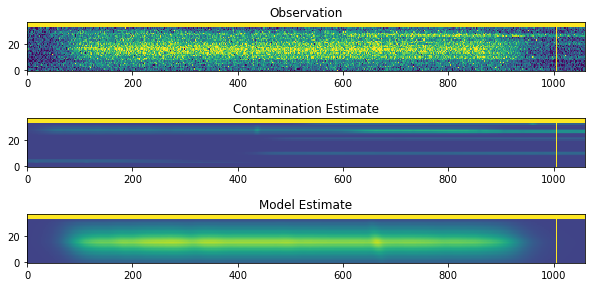

In [257]:
plt.rcParams["figure.figsize"] = (10,5)
plt.subplot(3,1,1)
im = plt.imshow(dd,norm=simple_norm(d,percent=96.),origin="corner",aspect=2.5)
plt.title("Observation")
plt.subplot(3,1,2)
plt.title("Contamination Estimate")
im = plt.imshow(cc,norm=simple_norm(d,percent=96.),origin="corner",aspect=2.5)
plt.subplot(3,1,3)
plt.title("Model Estimate")
im = plt.imshow(mm,norm=simple_norm(d,percent=96.),origin="corner",aspect=2.5)

<h3> Generate 1D spectrum

/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


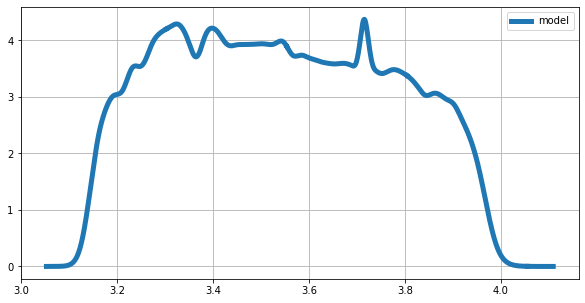

In [258]:
wav = ll[0]

# Hornes optimal extraction of model
t1 = np.nansum(mm*ww,axis=0)
t2 = np.nansum(ww**2,axis=0)
ext = t1/t2

plt.plot(wav,t1,lw=5,label="model")
plt.legend()
plt.grid()

/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


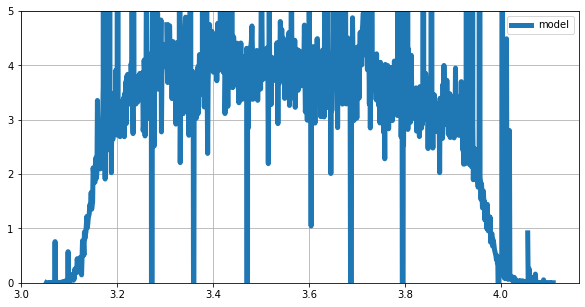

In [259]:
wav = ll[0]

# Hornes optimal extraction of  data-contam
t1 = np.nansum((dd-cc)*ww,axis=0)
t2 = np.nansum(ww**2,axis=0)
ext = t1/t2

plt.plot(wav,t1,lw=5,label="model")
plt.legend()
plt.ylim(0,5)
plt.grid()


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


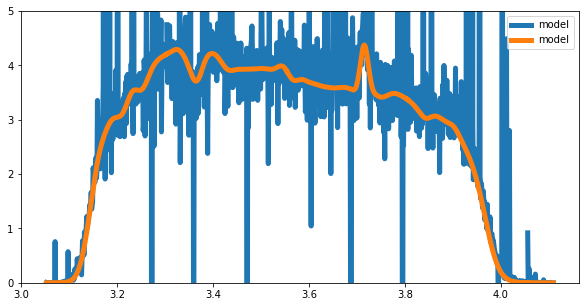

In [260]:
wav = ll[0]

# Hornes optimal extraction of  data-contam
t1 = np.nansum((dd-cc)*ww,axis=0)
t2 = np.nansum(ww**2,axis=0)
ext = t1/t2

plt.plot(wav,t1,lw=5,label="model")
plt.legend()
plt.ylim(0,5)
plt.grid()

# Hornes optimal extraction of model
t1 = np.nansum(mm*ww,axis=0)
t2 = np.nansum(ww**2,axis=0)
ext = t1/t2

plt.plot(wav,t1,lw=5,label="model")
plt.legend()
plt.grid()


<H3>Extracting and combining multiple observations

Define the name of the rate files to extract

In [261]:
ratenames = ["jw00042002001_01101_00001_nrca5_rate.fits","jw00042002001_01101_00002_nrca5_rate.fits","jw00042002001_01101_00003_nrca5_rate.fits"]
ratenames = [os.path.join("/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data",x) for x in ratenames]

In [313]:

def extract_multiple(ID,ra0,dec0,ratenames):
    dd = []
    ee = []
    qq = []
    ll = []
    cc = []
    mm = []
    ww = []
    yy = []
    rs = []


    dy = 50
    s = np.arange(-dy-0.5,dy+0.5+1,1) # bin edges


    bins = np.arange(3.05,4.12, 0.001)


    for i,ratename in enumerate(ratenames):
        print("Doing ",ratename,i+1,"of",len(ratenames))
        res = extract(ID,ra0,dec0,ratename)    
        if res==None:
            return None,None,None,None,None,None
        d, e, q, l, c, m, w, y, C = res

        # We ignore any pixels that had bad DQ to start with
        ok = (np.isfinite(d)) & (np.isfinite(l)) & (q==0)

        d = d[ok]
        e = e[ok]
        q = q[ok]
        l = l[ok]
        c = c[ok]
        m = m[ok]
        w = w[ok]
        y = y[ok]

        tmp = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(d),bins=[s,bins],statistic="mean")
        dd.append(tmp[0])

        tmp = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(d),bins=[s,bins],statistic="std")
        ee.append(tmp[0])

        tmp = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(q),bins=[s,bins],statistic="mean")
        qq.append(tmp[0])


        tmp = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(l),bins=[s,bins],statistic="mean")
        ll.append(tmp[0])


        tmp = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(c),bins=[s,bins],statistic="mean")
        cc.append(tmp[0])


        tmp = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(m),bins=[s,bins],statistic="mean")
        mm.append(tmp[0])


        tmp = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(w),bins=[s,bins],statistic="mean")
        ww.append(tmp[0])


        tmp = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(y),bins=[s,bins],statistic="mean")
        yy.append(tmp[0])

    dd = np.array(dd)
    cc = np.array(cc)
    mm = np.array(mm)
    ll = np.array(ll)
    yy = np.array(yy)

    
    fd = np.nanmedian(dd,axis=0)

    fc = np.nanmean(cc,axis=0)
    fm = np.nanmean(mm,axis=0)
    fl = np.nanmean(ll,axis=0)
    lam = np.nanmedian(fl,axis=0)
    fy = np.nanmean(yy,axis=0)

    
    ysum = np.nansum(fm,axis=0)
    w = np.repeat([ysum], np.shape(fm)[0], axis=0)
    fw = fm/w

    return fd,fc,fm,fw,fl,C




<h3> Extract multiple rate files

In [316]:
fd,fc,fm,fw,fl,C = extract_multiple(ID,ra0,dec0,ratenames)

Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  1056.4715452078938 1353.8013718337593


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  1176.1812032210682 1234.638357744204
Median data level: 1.0076669353484422
Estimated background level: 0.9940412707358777
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits 3 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits Target is at  1295.5418315653237 1115.606375857987
Median data level: 1.0078249864821816
Estimated background level: 0.994329784691824
3.05
4.109999999999999


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice


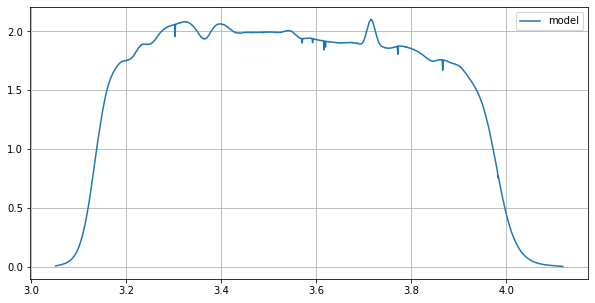

In [317]:
lam = np.nanmean(fl,axis=0)

# Hornes optimal extraction of model
t1 = np.nansum(fm*fw,axis=0)
t2 = np.nansum(fw**2,axis=0)
ext0 = t1/t2
plt.plot(lam,ext0,label="model")

plt.grid()
plt.legend()



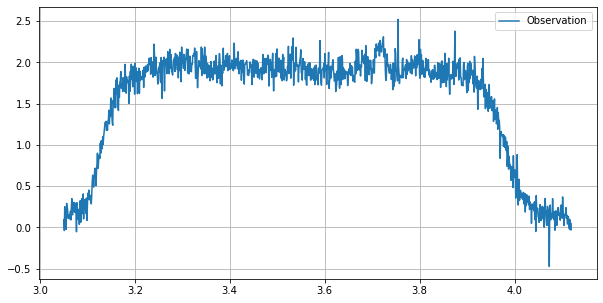

In [318]:
lam = np.nanmean(fl,axis=0)

# Hornes optimal extraction of model
t1 = np.nansum((fd-fc)*fw,axis=0)
t2 = np.nansum(fw**2,axis=0)
ext0 = t1/t2
plt.plot(lam,ext0,label="Observation")
plt.grid()
plt.legend()


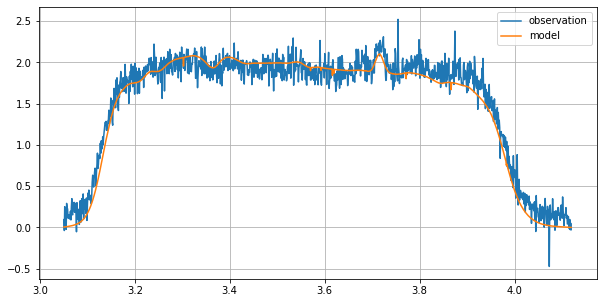

In [319]:
lam = np.nanmean(fl,axis=0)


# Hornes optimal extraction of model
t1 = np.nansum((fd-fc)*fw,axis=0)
t2 = np.nansum(fw**2,axis=0)
opt_extracted = t1/t2
plt.plot(lam,opt_extracted,label="observation")

t1 = np.nansum(fm*fw,axis=0)
t2 = np.nansum(fw**2,axis=0)
ext0 = t1/t2
plt.plot(lam,ext0,label="model")
plt.grid()
plt.legend()



<h3> Flux calibrate and compare to input spectrum

Load original Mirage input 1D spectrum for this source 

In [320]:
ref = h5py.File("/Users/npirzkal/Dropbox/mirage/CEERS_JADES3_galaxies.hdf5","r")
w0,f0 = ref["{}".format(ID)]
ref.close()

Apply sensitivity to extracted spectrum

/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


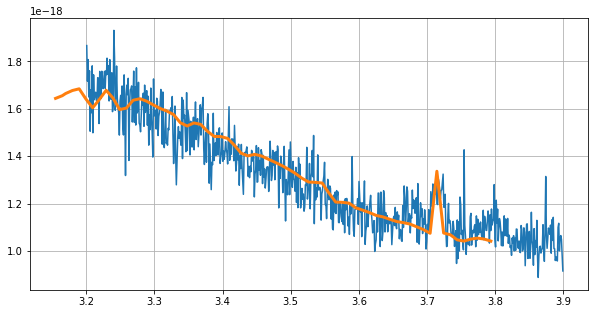

In [321]:
s = C.SENS["+1"](lam)
flux = opt_extracted/s /10

ok = (lam>3.2) & (lam<3.9)
plt.plot(lam[ok],flux[ok])


ok = (w0>3.15) & (w0<3.8)
plt.plot(w0[ok],f0[ok],lw=3)
plt.grid()
#plt.ylim(-0.1e-17,.32e-17)

<h3>Putting it all together

This simply runs the extraction and output results (plot and table) in the directory opath

In [396]:
def extract_ID(ID,catalog,ratenames,opath="/tmp/"):
    from astropy.table import Table
    
    if os.path.isfile(os.path.join(opath,"{}.done".format(ID))):
        #print(ID,"aready extracted")
        return
        
    cat = Table.read(catalog,format="ascii")
    ok = cat["index"]==ID
    ra0 = cat["x_or_RA"][ok][0]
    dec0 = cat["y_or_Dec"][ok][0]
    print("RA and DEC are:",ra0,dec0)



    fd,fc,fm,fw,fl,C = extract_multiple(ID,ra0,dec0,ratenames)
    if fd is None:
        return
    
    lam = np.nanmean(fl,axis=0)


    # Hornes optimal extraction of data
    t1 = np.nansum((fd-fc)*fw,axis=0)
    t2 = np.nansum(fw**2,axis=0)
    opt_extracted = t1/t2
    
    s = C.SENS["+1"](lam)
    flux_opt_extracted = opt_extracted/s /10 # 10A per pixel

    # Hornes optimal extraction of model
    t1 = np.nansum(fm*fw,axis=0)
    t2 = np.nansum(fw**2,axis=0)
    ext0 = t1/t2
    ext0_opt_extracted = ext0/s /10 # 10A per pixel


    plt.clf()
    plt.figure(figsize=(15,5))
    plt.subplot(2,1,1)
    plt.plot(lam,opt_extracted,label="observation")
    plt.plot(lam,ext0,label="model")
    plt.grid()
    plt.legend()
    plt.xlabel("Wavelength (A)")
    plt.ylabel("e-/s")
    plt.savefig(os.path.join(opath,"{}.pdf".format(ID)))

    res = Table()
    res["LAMBDA"] = lam
    res["Flux"] = opt_extracted
    res["Model"] = ext0
    res.write(os.path.join(opath,"{}.table".format(ID)),format="ascii")
    
    open(os.path.join(opath,"{}.done".format(ID)),"w").writelines([])

RA and DEC are: 215.0496555911 52.9268016832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  234.062600977261 1123.1279012507716


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  354.75343388628187 1005.0898773164137
Median data level: 1.0076669353484422
Estimated background level: 0.9940412707358777
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits 3 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits Target is at  475.22340853124035 887.1427313522893
Median data level: 1.0078249864821816
Estimated background level: 0.994329784691824
3.05
4.109999999999999


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirag

<Figure size 720x360 with 0 Axes>

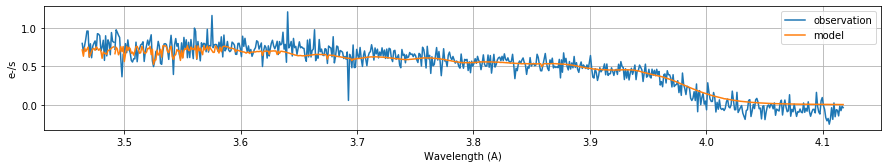

In [397]:
catalog = "/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/catalogs/JWSTSIMS-56.cat"
extract_ID(14923,catalog,ratenames)

<h2> Extracting multiple objects

108544 24.718433
124928 23.96973
RA and DEC are: 215.0178685911 52.9327856832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  1335.6094058023361 1469.9347616808602
75779 25.933475
RA and DEC are: 214.9975295911 52.9340636832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  2039.432185518915 1538.2306955201152
67588 25.966763
RA and DEC are: 215.0068485911 52.9277976832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  17

/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  1091.2321854970824 1879.06353478354
Median data level: 1.0076669353484422
Estimated background level: 0.9940412707358777
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits 3 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits Target is at  1211.2996992725884 1759.0930123276353
Median data level: 1.0078249864821816
Estimated background level: 0.994329784691824
3.05
4.109999999999999


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirag

10 24.725117
88075 24.659409
38924 25.918461
RA and DEC are: 215.0468685911 52.9244046832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  331.68247588371037 986.896018704364
143374 24.587322
RA and DEC are: 215.0375675911 52.9295026832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  652.0437167227925 1280.947444849514
256016 25.721497
RA and DEC are: 215.0115235911 52.9235996832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Targe

/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  2231.869362064909 1656.8694122112265
Median data level: 1.0076669353484422
Estimated background level: 0.9940412707358777
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits 3 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits Target is at  2348.974548314917 1536.464649251606
Median data level: 1.0078249864821816
Estimated background level: 0.994329784691824
3.05
4.109999999999999


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirag

73755 24.33919
12318 23.319622
153631 24.435024
81954 25.948605
RA and DEC are: 215.0443895911 52.9436266832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  411.98143108989484 2092.148486953885
180263 25.616426
RA and DEC are: 214.9943325911 52.9108336832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  2133.850611407419 222.8525807378851


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  2249.1373193440304 106.36013475309176
Median data level: 1.0076669353484422
Estimated background level: 0.9940412707358777
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits 3 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits Target is at  2363.7369708249857 -9.651094546914692
8233 25.059036
RA and DEC are: 215.0197265911 52.9209496832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage

/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirag

186458 25.547571
RA and DEC are: 215.0245015911 52.9277716832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  1105.1264896785283 1183.1584137072728


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  1224.5830508137888 1064.2809462788462
Median data level: 1.0076669353484422
Estimated background level: 0.9940412707358777
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits 3 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits Target is at  1343.6687518791507 945.5681710204076
Median data level: 1.0078249864821816
Estimated background level: 0.994329784691824
3.05
4.109999999999999


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirag

39001 24.808865
206944 25.245752
RA and DEC are: 215.0122495911 52.9206086832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  1526.8063304142902 774.9673448834947
62706 23.822102
4091 22.45377
141415 25.038004
RA and DEC are: 215.0148545911 52.9343486832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  1440.5247086464235 1559.125334034515


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  1559.6510031696555 1439.3306261361333
Median data level: 1.0076669353484422
Estimated background level: 0.9940412707358777
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits 3 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits Target is at  1678.3792089106587 1319.666595035711
Median data level: 1.0078249864821816
Estimated background level: 0.994329784691824
3.05
4.109999999999999


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirag

6250 23.660389
RA and DEC are: 215.0209265911 52.9082406832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  1228.2020555423119 76.64185430405098


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  1346.0407537171914 -39.382402657040984
32876 21.186451
119 25.974283
RA and DEC are: 215.0380245911 52.9322696832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  635.6125687107334 1439.6126133410864
110716 23.941631
RA and DEC are: 215.0285245911 52.9187266832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001

/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirag

104588 24.713345
141453 24.632362
166031 25.285282
RA and DEC are: 215.0206545911 52.9107376832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  1237.4233304488152 216.8705490387356


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  1355.4415611115082 100.38852006080197
Median data level: 1.0076669353484422
Estimated background level: 0.9940412707358777
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits 3 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits Target is at  1472.9824063876415 -15.739616420715947
96398 25.157848
RA and DEC are: 215.0040975911 52.9422336832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mira

/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirag

26770 25.388866
RA and DEC are: 215.0424345911 52.9198326832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  486.9669639732616 727.4165063960734


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  607.031780714649 609.9394141163546
Median data level: 1.0076669353484422
Estimated background level: 0.9940412707358777
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits 3 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits Target is at  726.7941537045117 492.6464929905429
Median data level: 1.0078249864821816
Estimated background level: 0.994329784691824
3.05
4.109999999999999


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirag

51351 24.213711
77976 25.9524
RA and DEC are: 215.0172935911 52.9239016832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  1353.834704911982 962.3311512276795


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  1472.5273159515546 843.7817259365364
Median data level: 1.0076669353484422
Estimated background level: 0.9940412707358777
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits 3 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits Target is at  1590.7889764087117 725.4579728048169
Median data level: 1.0078249864821816
Estimated background level: 0.994329784691824
3.05
4.109999999999999


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirag

12442 24.864979
RA and DEC are: 215.0074025911 52.9245946832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  1694.756807053402 1000.9903003499273
233637 25.982218
RA and DEC are: 215.0112475911 52.9113606832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  1558.8506062224278 252.68764450399658
213157 25.975071
RA and DEC are: 215.0404835911 52.9401606832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  548.7718279083506

/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  731.0106049556357 1554.998048855822
Median data level: 1.0076669353484422
Estimated background level: 0.9940412707358777
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits 3 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits Target is at  851.4056437271671 1435.7888295111334
Median data level: 1.0078249864821816
Estimated background level: 0.994329784691824
3.05
4.109999999999999


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirag

139454 25.531487
RA and DEC are: 215.0000835911 52.9344906832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  1951.6352284788688 1563.5497635454017


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  2069.485572364306 1443.448675697091
Median data level: 1.0076669353484422
Estimated background level: 0.9940412707358777
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits 3 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits Target is at  2186.8417311046187 1323.5258490122173
Median data level: 1.0078249864821816
Estimated background level: 0.994329784691824
3.05
4.109999999999999


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirag

65727 25.967327
RA and DEC are: 215.0156465911 52.9204336832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  1409.9764989681548 765.1195818337649


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  1528.3001931044632 647.0245808793732
Median data level: 1.0076669353484422
Estimated background level: 0.9940412707358777
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits 3 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits Target is at  1646.1660821947412 529.1955602272171
Median data level: 1.0078249864821816
Estimated background level: 0.994329784691824
3.05
4.109999999999999


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirag

198846 23.285774
121025 24.141979
RA and DEC are: 215.0292635911 52.9099086832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  943.064429709697 168.8506760311849


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  1061.691734895505 52.60414558992852
Median data level: 1.0076669353484422
Estimated background level: 0.9940412707358777
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits 3 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits Target is at  1179.8912126910193 -63.311332118118116
65730 24.574074
RA and DEC are: 215.0132035911 52.9129586832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage

/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirag

28866 25.809578
RA and DEC are: 215.0170385911 52.9408746832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  1366.4726074785303 1934.0515670694854


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  1486.0831028744915 1813.775101355263
Median data level: 1.0076669353484422
Estimated background level: 0.9940412707358777
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits 3 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits Target is at  1605.3392026567267 1693.5508865703032
Median data level: 1.0078249864821816
Estimated background level: 0.994329784691824
3.05
4.109999999999999


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirag

6346 25.5686
RA and DEC are: 215.0265615911 52.9397006832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  1034.4338163948328 1867.588204529584
22731 23.610176
RA and DEC are: 215.0077365911 52.9438916832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  1691.2226106471771 2104.7813564252574
53453 24.22068
RA and DEC are: 215.0391525911 52.9097726832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  604.6902377971358 158.8

/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  1698.6214479148448 101.02742625114479
Median data level: 1.0076669353484422
Estimated background level: 0.9940412707358777
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits 3 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits Target is at  1815.176009289653 -15.110450976086895
243922 25.936657
RA and DEC are: 215.0459805911 52.9362516832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mira

/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirag

8406 25.042263
RA and DEC are: 215.0437565911 52.9162786832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  443.24297189968 525.1262793895783


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  563.1738413712637 408.1549223766975
Median data level: 1.0076669353484422
Estimated background level: 0.9940412707358777
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits 3 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits Target is at  682.7939160281342 291.3987437615873
Median data level: 1.0078249864821816
Estimated background level: 0.994329784691824
3.05
4.109999999999999


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirag

180440 25.246624
RA and DEC are: 215.0306115911 52.9148246832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  895.6501294586373 445.88206431791116


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  1014.7206861074741 328.8521657781905
Median data level: 1.0076669353484422
Estimated background level: 0.9940412707358777
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits 3 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits Target is at  1133.3959618990302 212.09428745445473
Median data level: 1.0078249864821816
Estimated background level: 0.994329784691824
3.05
4.109999999999999


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirag

192732 25.114603
RA and DEC are: 215.0401065911 52.9298086832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  563.8688039340946 1298.0080476721062


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  684.3101344136342 1179.3570283361553
Median data level: 1.0076669353484422
Estimated background level: 0.9940412707358777
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits 3 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits Target is at  804.483146620109 1060.7993539191762
Median data level: 1.0078249864821816
Estimated background level: 0.994329784691824
3.05
4.109999999999999


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirag

207073 25.485607
RA and DEC are: 214.9974425911 52.9356256832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  2043.3666367158385 1627.400489304473


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  2161.024534112 1507.1379410624945
Median data level: 1.0076669353484422
Estimated background level: 0.9940412707358777
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits 3 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits Target is at  2278.1741485943185 1387.0507424841687
Median data level: 1.0078249864821816
Estimated background level: 0.994329784691824
3.05
4.109999999999999


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirag

104674 24.735332
241890 22.995705
22758 23.2869
30951 22.242641
RA and DEC are: 215.0322535911 52.9086916832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  841.1653741832203 99.8107847731194


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  959.914935909937 -16.184665140409834
219371 25.05648
RA and DEC are: 215.0021885911 52.9198886832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  1871.629558766128 733.2699971833531
131308 25.775042
RA and DEC are: 215.0156525911 52.9340766832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca

/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirag

96494 25.580044
RA and DEC are: 215.0028825911 52.9243926832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  1850.0277376025397 988.7809915750273


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  1967.4647659954326 869.9710709765741
Median data level: 1.0076669353484422
Estimated background level: 0.9940412707358777
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits 3 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits Target is at  2084.3783103986325 751.4337467999796
Median data level: 1.0078249864821816
Estimated background level: 0.994329784691824
3.05
4.109999999999999


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirag

170222 23.79459
139504 25.859409
RA and DEC are: 215.0154395911 52.9229506832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  1417.5709608227673 908.1506222146564


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  1536.0505002222585 789.6986222128627
Median data level: 1.0076669353484422
Estimated background level: 0.9940412707358777
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits 3 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits Target is at  1654.0832414729525 671.488009826603
Median data level: 1.0078249864821816
Estimated background level: 0.994329784691824
3.05
4.109999999999999


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirag

157938 25.411419
RA and DEC are: 214.9980145911 52.9246506832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  2017.1608927639084 1002.4000526951129


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  2134.1102797335257 883.5126848976704
Median data level: 1.0076669353484422
Estimated background level: 0.9940412707358777
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits 3 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits Target is at  2250.5005927256298 764.9145626126196
Median data level: 1.0078249864821816
Estimated background level: 0.994329784691824
3.05
4.109999999999999


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirag

14579 21.386742
121076 23.897409
129272 25.956249
RA and DEC are: 215.0300675911 52.9356136832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  912.0553641565907 1632.5605238569115


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  1032.241990560935 1513.0767123671505
Median data level: 1.0076669353484422
Estimated background level: 0.9940412707358777
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits 3 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits Target is at  1152.1278625826124 1393.659737069871
Median data level: 1.0078249864821816
Estimated background level: 0.994329784691824
3.05
4.109999999999999


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirag

180473 25.568857
RA and DEC are: 215.0529075911 52.9176646832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  127.64455641657798 600.7304621504626
30969 23.481022
35067 21.253353
49402 25.427166
RA and DEC are: 215.0196945911 52.9253626832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  1271.1719919652526 1045.6341385099015
110846 25.510798
RA and DEC are: 215.0111445911 52.9175206832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits

/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  1681.6396008254894 482.2825209403477
Median data level: 1.0076669353484422
Estimated background level: 0.9940412707358777
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits 3 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits Target is at  1798.8501382404274 364.8936300336429
Median data level: 1.0078249864821816
Estimated background level: 0.994329784691824
3.05
4.109999999999999


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirag

24829 24.25909
84219 24.116997
43267 25.124554
RA and DEC are: 215.0381465911 52.9111236832
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  638.4654453037128 235.200496284549


/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/npirzkal/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Median data level: 1.0165241642434855
Estimated background level: 1.002096996309166
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  757.7683730377446 118.88519245440057
Median data level: 1.0076669353484422
Estimated background level: 0.9940412707358777
3.05
4.109999999999999
Doing  /Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits 3 of 3
Filter: F356W
grism: R
Module: A
/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00003_nrca5_rate.fits Target is at  876.7028827107694 2.8566997696580074
Median data level: 1.0078249864821816
Estimated background level: 0.994329784691824
3.05
4.109999999999999


ValueError: zero-size array to reduction operation minimum which has no identity

<Figure size 720x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

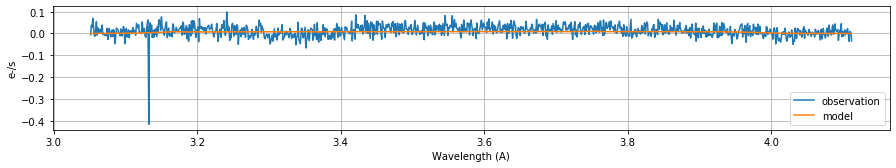

In [404]:
from astropy.io import fits
with fits.open("/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/data/jw00042002001_01101_00005_nrca5_uncal_F356W_seed_image.fits") as fin:
    seq = fin[2].data
    
IDs = list(set(np.ravel(seq)))
for ID in IDs:
    ID = int(ID)
    if ID==0.: continue
    ok = cat["index"]==ID
    m = cat["nircam_f335m_magnitude"][ok][0]
    
    if m<26:
        print(ID,m)
        extract_ID(ID,catalog,ratenames,opath="/tmp/extracted")

In [399]:
catalog

'/Users/npirzkal/Dropbox/mirage/JWSTSIMS-56/catalogs/JWSTSIMS-56.cat'